## 1. Import Library

mengimpor berbagai library yang dibutuhkan. Library seperti `pandas` dan `numpy` digunakan untuk manipulasi data, `matplotlib` dan `seaborn` untuk visualisasi data, serta `tensorflow.keras` untuk membangun model deep learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## 2. Load Dataset

memuat dataset transaksi yang akan digunakan untuk analisis dan prediksi.


In [3]:
df = pd.read_csv('/content/spend_analysis_dataset.csv')

## 3. Data Understanding
Pada tahapan ini kita melihat struktur awal data.

### Menampilkan 5 data teratas
Digunakan untuk melihat struktur awal data.

In [4]:
print(df.head())

  TransactionID                 ItemName         Category  Quantity  \
0        TXN001               Desk Chair        Furniture        10   
1        TXN002                  Stapler  Office Supplies        16   
2        TXN003  Annual Software License         Software         1   
3        TXN004                  Notepad       Stationery        13   
4        TXN005                  Notepad       Stationery        19   

   UnitPrice  TotalCost PurchaseDate         Supplier            Buyer  
0     113.15    1131.50   2024-04-19    TechMart Inc.     Kelly Joseph  
1      12.62     201.92   2024-07-06  CloudSoft Corp.     Kelly Joseph  
2    5649.34    5649.34   2024-09-10    TechMart Inc.     Kelly Joseph  
3       2.92      37.96   2024-01-21  FurniWorks Ltd.     Luis Holland  
4       1.39      26.41   2024-02-03    TechMart Inc.  Cynthia Jenkins  


### Cek informasi dataset
Digunakan untuk mengetahui jumlah kolom, tipe data, dan apakah ada nilai kosong.


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TransactionID  500 non-null    object 
 1   ItemName       500 non-null    object 
 2   Category       500 non-null    object 
 3   Quantity       500 non-null    int64  
 4   UnitPrice      500 non-null    float64
 5   TotalCost      500 non-null    float64
 6   PurchaseDate   500 non-null    object 
 7   Supplier       500 non-null    object 
 8   Buyer          500 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 35.3+ KB
None


### Cek missing values
Penting untuk melihat apakah ada data yang hilang dan perlu ditangani.

In [6]:
print(df.isnull().sum())

TransactionID    0
ItemName         0
Category         0
Quantity         0
UnitPrice        0
TotalCost        0
PurchaseDate     0
Supplier         0
Buyer            0
dtype: int64


### Cek duplikat
melihat apakah ada data duplikat

In [7]:
print(df.duplicated().sum())

0


## Exploratory Data Analysis (EDA)
melakukan eksplorasi data

### Statistik Deskriptif
Memberikan gambaran umum distribusi dan nilai-nilai statistik tiap fitur numerik.

In [8]:
df.describe()

Quantity    UnitPrice    TotalCost
count  500.000000   500.000000    500.00000
mean     9.640000   854.245100   2481.16106
std      6.168834  2132.890832   3527.35316
min      1.000000     1.060000      1.56000
25%      4.000000    14.380000    145.92750
50%     10.000000   143.595000    918.56000
75%     15.000000   287.925000   3123.56750
max     20.000000  9909.240000  18494.60000

### Plot distribusi TotalCost
Visualisasi distribusi kolom target (TotalCost) untuk mengidentifikasi outlier dan pola umum.



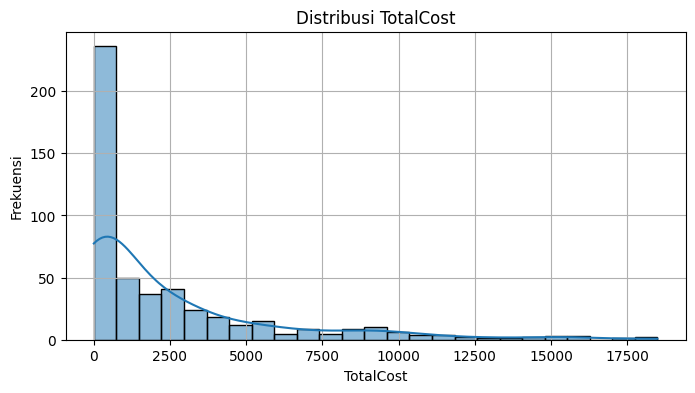

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(df['TotalCost'], kde=True)
plt.title('Distribusi TotalCost')
plt.xlabel('TotalCost')
plt.ylabel('Frekuensi')
plt.grid()
plt.show()

### Korelasi Quantity, UnitPrice, TotalCost
Menampilkan korelasi antar fitur numerik untuk memahami hubungan antar fitur.


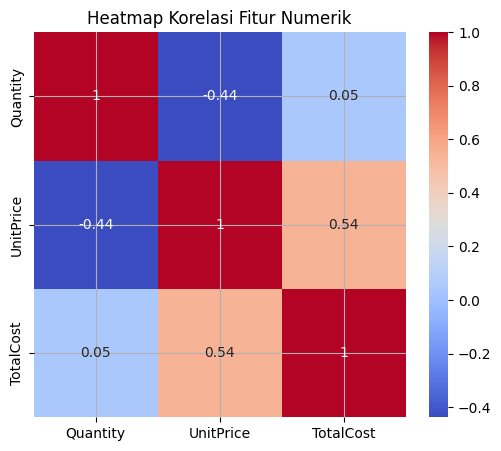

In [10]:
plt.figure(figsize=(6,5))
sns.heatmap(df[['Quantity', 'UnitPrice', 'TotalCost']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.grid()
plt.show()

## 4. Data Preparation

### Konversi Kolom Tanggal dan Set Index
Mengubah kolom tanggal menjadi format datetime dan menjadikannya index agar bisa digunakan untuk resampling.

In [11]:
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])
df = df[['PurchaseDate', 'TotalCost']]
df.set_index('PurchaseDate', inplace=True)

### Resample Data Bulanan
Mengelompokkan data per bulan agar pola musiman dapat dianalisis.

In [12]:
df_monthly = df.resample('M').sum()

<ipython-input-12-47a25ff98584>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').sum()


### Scaling dan Membuat Windowed Dataset
LSTM membutuhkan data dalam bentuk yang terstandardisasi dan dalam bentuk window time series.

In [13]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_monthly)

def create_windowed_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 3
X, y = create_windowed_dataset(df_scaled, window_size)

split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## 5. Modeling

### Model 1: LSTM

#### Cara Kerja:
LSTM (Long Short-Term Memory) adalah jenis Recurrent Neural Network (RNN) yang digunakan untuk menangani data sekuensial seperti data time series. LSTM memiliki kemampuan untuk mengingat informasi dalam jangka panjang, sehingga cocok untuk prediksi berdasarkan urutan waktu.

#### Arsitektur dan Parameter:
- `LSTM(64, activation='relu')`: Layer LSTM dengan 64 unit dan fungsi aktivasi ReLU.
- `Dense(1)`: Layer output untuk prediksi nilai tunggal.
- Optimizer: `adam`, Loss function: `mse` (Mean Squared Error).
- Parameter lain menggunakan default.

In [14]:
#LTSM
model = Sequential([
    LSTM(64, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 6. Training
Model dilatih dengan data training, dan menggunakan early stopping untuk menghentikan pelatihan jika validasi tidak membaik dalam 10 epoch berturut-turut.


In [15]:
history = model.fit(
    X_train, y_train,
    epochs=130,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5349 - val_loss: 0.4892
Epoch 2/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.5262 - val_loss: 0.4757
Epoch 3/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5178 - val_loss: 0.4626
Epoch 4/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.5097 - val_loss: 0.4498
Epoch 5/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.5020 - val_loss: 0.4374
Epoch 6/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4945 - val_loss: 0.4253
Epoch 7/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4871 - val_loss: 0.4134
Epoch 8/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.4799 - val_loss: 0.4017
Epoch 9/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4728 - val_loss: 0.3903
Epoch 10/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.4659 - val_loss: 0.3790
Epoch 11/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4590 - val_loss: 0.3679
Epoch 12/130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.4522 - val_l

## 7. Evaluasi Model

### Apa itu Metrik Evaluasi?
- **MAE (Mean Absolute Error)**: Rata-rata kesalahan absolut antara nilai aktual dan prediksi. Semakin kecil nilainya, semakin akurat model.
- **RMSE (Root Mean Squared Error)**: Akar dari rata-rata kuadrat kesalahan. Lebih sensitif terhadap outlier daripada MAE.

### Hasil Evaluasi
Model diuji dengan data test. Nilai prediksi dan aktual dikembalikan ke skala aslinya (inverse transform) untuk dihitung metrik evaluasinya.



In [16]:
# Prediksi
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


### Inverse transform hasil prediksi dan y_test

 mengembalikan hasil prediksi (y_pred) dan data aktual (y_test) ke skala aslinya (sebelum dilakukan scaling). Hal ini penting agar kita dapat membandingkan hasil prediksi dengan nilai aktual dalam satuan yang sebenarnya

In [17]:
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), df_monthly.shape[1]-1)), y_pred), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), df_monthly.shape[1]-1)), y_test), axis=1))[:, -1]

 menghitung nilai Mean Absolute Error (MAE) dan Root Mean Squared Error (RMSE) untuk mengukur performa model dalam memprediksi total biaya (TotalCost).

In [18]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 4589.25
RMSE: 4760.40


### Visualisasi Prediksi vs Aktual
Visualisasi ini bertujuan untuk melihat seberapa dekat hasil prediksi dengan nilai aktualnya.


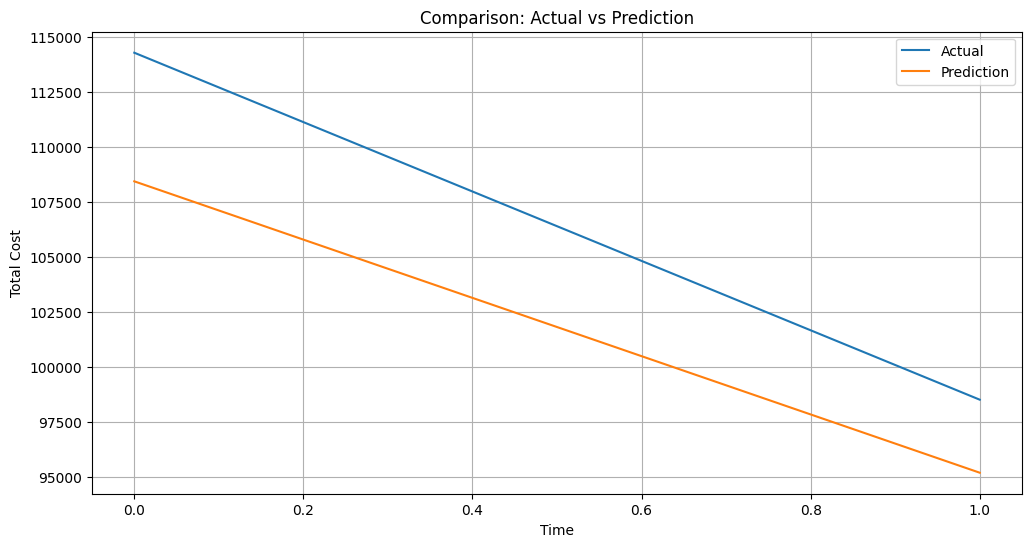

In [20]:
# Plot hasil prediksi vs aktual
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Prediction')
plt.legend()
plt.title('Comparison: Actual vs Prediction')
plt.xlabel('Time')
plt.ylabel('Total Cost')
plt.grid()
plt.show()


### Insight Evaluasi:
- Model mampu mengikuti tren data pengeluaran bulanan dengan cukup baik.

- MAE = 4589.25 → menunjukkan bahwa rata-rata kesalahan prediksi hanya sekitar 4,5 ribu satuan, yang tergolong rendah dan menandakan model cukup akurat.

- RMSE = 4760.40 → menunjukkan kesalahan prediksi keseluruhan relatif kecil, menunjukkan performa model yang stabil dan akurat.


